### convGNP is Trained using a trainer class. that implements SGD using an Adam Optimizer.
* Goal : spatially interpolate, daily average era5, 2m temperature over North America.
* Context Data : ERA5 reanalysis data 100km Earth Env, elevation data, and GLDAS mask data.
* Training period: 2010-2018.
* Validation period: 2019.

In [1]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [2]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 2
extent = "north_america"
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "mycache"
deepsensor_folder = "deepsensor_config/"
verbose_download = True

In [3]:
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

In [4]:
lowres_aux_raw_ds

<xarray.Dataset> Size: 36kB
Dimensions:    (lon: 120, lat: 72)
Coordinates:
  * lon        (lon) float64 960B -159.6 -158.8 -157.9 ... -62.08 -61.25 -60.42
  * lat        (lat) float64 576B 74.42 73.58 72.75 71.92 ... 16.92 16.08 15.25
Data variables:
    elevation  (lat, lon) float32 35kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 33.05 0.0

In [5]:
land_mask_raw_ds

<xarray.DataArray 'GLDAS_mask' (lat: 240, lon: 400)> Size: 384kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lon      (lon) float32 2kB -159.9 -159.6 -159.4 ... -60.62 -60.38 -60.12
  * lat      (lat) float32 960B 74.88 74.62 74.38 74.12 ... 15.62 15.38 15.12

In [6]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)

100%|██████████| 120/120 [00:01<00:00, 93.84it/s]


1.41 GB loaded in 1.56 s


In [7]:
era5_raw_ds

<xarray.Dataset> Size: 1GB
Dimensions:         (time: 3652, lat: 241, lon: 401)
Coordinates:
  * lat             (lat) float32 964B 75.0 74.75 74.5 74.25 ... 15.5 15.25 15.0
  * lon             (lon) float32 2kB -160.0 -159.8 -159.5 ... -60.25 -60.0
  * time            (time) datetime64[ns] 29kB 2010-01-01 ... 2019-12-31
Data variables:
    2m_temperature  (time, lat, lon) float32 1GB 251.1 251.1 ... 299.8 299.8
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

In [9]:
data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds, method="min_max")

In [10]:
era5_ds

<xarray.Dataset> Size: 1GB
Dimensions:         (time: 3652, x1: 241, x2: 401)
Coordinates:
  * time            (time) datetime64[ns] 29kB 2010-01-01 ... 2019-12-31
  * x1              (x1) float32 964B 0.6 0.5975 0.595 ... 0.005 0.0025 0.0
  * x2              (x2) float32 2kB 0.0 0.0025 0.005 ... 0.995 0.9975 1.0
Data variables:
    2m_temperature  (time, x1, x2) float32 1GB -0.2792 -0.2787 ... 0.7001 0.6993
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

In [11]:
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

In [14]:
lowres_aux_ds

<xarray.Dataset> Size: 124kB
Dimensions:    (x1: 72, x2: 120, time: 3652)
Coordinates:
  * x1         (x1) float64 576B 0.5942 0.5858 0.5775 ... 0.01917 0.01083 0.0025
  * x2         (x2) float64 960B 0.004167 0.0125 0.02083 ... 0.9875 0.9958
  * time       (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
Data variables:
    elevation  (x1, x2) float32 35kB -1.0 -1.0 -1.0 -1.0 ... -1.0 -0.9795 -1.0
    cos_D      (time) float64 29kB 0.9999 0.9994 0.9987 ... 0.9993 0.9998 1.0
    sin_D      (time) float64 29kB 0.0172 0.0344 0.05158 ... -0.0215 -0.004301

In [15]:
set_gpu_default_device()

### Initialise taskloader and convNP model.


In [16]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [64]:
# set up model 
model = ConvNP(data_processor, task_loader, unet_channels = (32,32,32,32,32))


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [np.float32(0.00125), np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


### Define how tasks are generated.

In [65]:
# Genrate tasks for a set of dates, by randomly sampling between 0 and ERA5 grid cells, as context points and passing all ERA5 grid cells as target points.
#All auxilliary data will be passed as context points.

In [66]:
def gen_tasks(dates, progress = True):
    tasks = []
    for date in tqdm_notebook(dates, disable = not progress):
        N_c = np.random.randint(0,500)
        task = task_loader(date, context_sampling=[N_c, "all", "all"], target_sampling="all")
        tasks.append(task)
    return tasks

### Generate validations tasks for testing generalisation

In [67]:
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]
val_tasks = gen_tasks(val_dates)

  0%|          | 0/183 [00:00<?, ?it/s]

### Print number of model parameters

In [68]:
_ = model(val_tasks[0])
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

Model has 339,590 parameters


### Training with the trainer class
* Trainer class is initialised with the convNP model and an optional learning rate.
* Trainer object with a list of tasks, will perform a single epoch of training and return a list of losses of each task.
* The trainer class also implements a train method, which will train the model for a specified number of epochs and returns a list of losses for each epoch

In [69]:
task_loader.target_var_IDs

(('2m_temperature',),)

In [70]:
for task in val_tasks:
    print(task)
    break

time: 2019-01-01 00:00:00
ops: []
X_c: [(2, 148), ((1, 240), (1, 400)), ((1, 72), (1, 120))]
Y_c: [(1, 148), (1, 240, 400), (3, 72, 120)]
X_t: [((1, 241), (1, 401))]
Y_t: [(1, 241, 401)]



In [71]:
# Train the model for 50 epochs and save the model for best validation RMSE.
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = "2m_temperature"
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task),target_var_ID, unnorm= True)
        true = data_processor.map_array(task["Y_t"][0],target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors)**2))

In [ ]:
def compute_std(model,val_tasks):
    stds = []
    for task in val_tasks:
        pred = model.predict(task, X_t=era5_raw_ds)
        stds.append(pred['2m_temperature']['std'].to_dataframe().mean()[0])

    return np.mean(stds)

In [83]:
untrained_rmse = compute_val_rmse(model,val_tasks)
print(untrained_rmse)

untrained_std = compute_std(model,val_tasks)
print(untrained_std)

2.3516736
2.0048964


In [74]:
losses = []
val_rmses = []
stds =  []
epochs =  25

In [75]:
# train model
val_rmse_best = np.inf
trainer = Trainer(model, lr = 5e-5)
for epoch in tqdm_notebook(range(epochs)):
    train_tasks = gen_tasks(pd.date_range(train_range[0], train_range[1])[::date_subsample_factor], progress= False)
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))
    val_rmses.append(compute_val_rmse(model,val_tasks))
    stds.append(compute_std(model,val_tasks))
    print("Epoch {} | Error {:.2f} | std {:.2f}".format(epoch+1,val_rmses[-1],stds[-1]))
    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]
        # model.save(deepsensor_folder)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 | Error 4.91 | std 4.77
Epoch 2 | Error 4.29 | std 3.68
Epoch 3 | Error 4.14 | std 3.80
Epoch 4 | Error 3.94 | std 3.60
Epoch 5 | Error 4.24 | std 3.53
Epoch 6 | Error 4.19 | std 3.79
Epoch 7 | Error 3.89 | std 3.36
Epoch 8 | Error 3.72 | std 3.49
Epoch 9 | Error 3.79 | std 3.41
Epoch 10 | Error 3.74 | std 3.09
Epoch 11 | Error 3.50 | std 3.01
Epoch 12 | Error 3.40 | std 3.19
Epoch 13 | Error 3.42 | std 2.91
Epoch 14 | Error 3.36 | std 3.05
Epoch 15 | Error 3.69 | std 2.82
Epoch 16 | Error 3.19 | std 2.85
Epoch 17 | Error 3.38 | std 2.90
Epoch 18 | Error 3.06 | std 2.67
Epoch 19 | Error 2.81 | std 2.52
Epoch 20 | Error 2.77 | std 2.40
Epoch 21 | Error 2.74 | std 2.34
Epoch 22 | Error 2.55 | std 2.32
Epoch 23 | Error 2.80 | std 2.22
Epoch 24 | Error 2.54 | std 2.47
Epoch 25 | Error 2.35 | std 2.00


In [ ]:
# model.save("./deepsensor_folder/")                 

TypeError: Object of type float32 is not JSON serializable

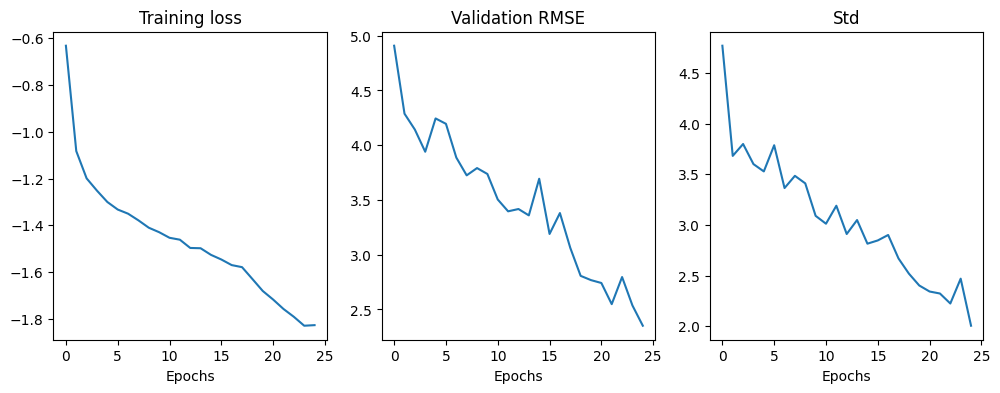

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
axes[2].plot(stds)
_ = axes[0].set_xlabel("Epochs")
_ = axes[1].set_xlabel("Epochs")
_ = axes[2].set_xlabel("Epochs")
_ = axes[0].set_title("Training loss")
_ = axes[1].set_title("Validation RMSE")
_ = axes[2].set_title("Std")

In [63]:
era5_raw_ds

<xarray.Dataset> Size: 1GB
Dimensions:         (time: 3652, lat: 241, lon: 401)
Coordinates:
  * lat             (lat) float32 964B 75.0 74.75 74.5 74.25 ... 15.5 15.25 15.0
  * lon             (lon) float32 2kB -160.0 -159.8 -159.5 ... -60.25 -60.0
  * time            (time) datetime64[ns] 29kB 2010-01-01 ... 2019-12-31
Data variables:
    2m_temperature  (time, lat, lon) float32 1GB 251.1 251.1 ... 299.8 299.8
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

In [78]:
### Visualise trained model predictions
date = "2019-06-25"
# test_task = task_loader(date, [200, "all", "all"], seed_override=42)
test_task = task_loader(date, context_sampling=[200, "all", "all"])
# task_loader.load_dask()
pred = model.predict(test_task, X_t=era5_raw_ds)

In [79]:
print(pred)

Prediction({'2m_temperature': ('mean', 'std')}), mode=on-grid


In [80]:
pred

{'2m_temperature': <xarray.Dataset> Size: 776kB
 Dimensions:  (time: 1, lat: 241, lon: 401)
 Coordinates:
   * lat      (lat) float32 964B 75.0 74.75 74.5 74.25 ... 15.75 15.5 15.25 15.0
   * lon      (lon) float32 2kB -160.0 -159.8 -159.5 ... -60.5 -60.25 -60.0
   * time     (time) datetime64[ns] 8B 2019-06-25
 Data variables:
     mean     (time, lat, lon) float32 387kB 272.1 273.7 274.4 ... 301.0 300.2
     std      (time, lat, lon) float32 387kB 2.162 1.73 1.493 ... 1.159 1.422}

In [81]:
pred['2m_temperature']['std'].to_dataframe().mean()

std    1.764604
dtype: float32

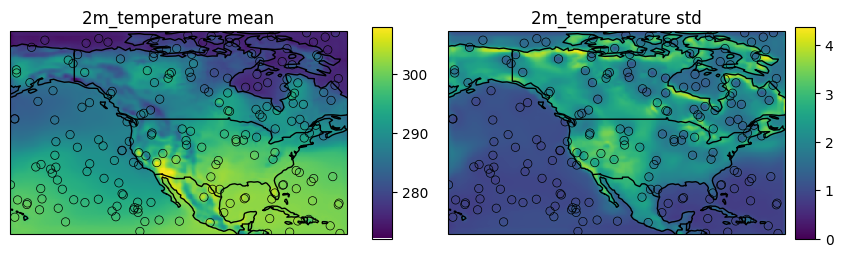

In [84]:
fig = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task, crs=ccrs.PlateCarree())